In [43]:
## Get data

import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from trajectory import rat_trajectory, rat_trajectory_PV
from scipy.interpolate import interp1d

#Perameters
mouse_num = 2
inactivation = True

if mouse_num == 1 and not inactivation:
    spk_filename = f'data/PV_inactivation/JY/mouse1 - base and opto/Square50_B1O1B2O2_PV5_6_Base1_deconv.xlsx'
    trc_filename = f'data/PV_inactivation/JY/mouse1 - base and opto/Square50_B1O1B2O2_PV5_6_Base1.xlsx'
elif mouse_num == 1 and inactivation:
    spk_filename = f'data/PV_inactivation/JY/mouse1 - base and opto/Square50_B1O1B2O2_PV5_6_Opto1_deconv.xlsx'
    trc_filename = f'data/PV_inactivation/JY/mouse1 - base and opto/Square50_B1O1B2O2_PV5_6_Opto1.xlsx'
elif mouse_num == 2 and not inactivation:
    spk_filename = f'data/PV_inactivation/JY/mouse2 - base and opto/Square50_BO_PV5_7_Base_deconv.xlsx'
    trc_filename = f'data/PV_inactivation/JY/mouse2 - base and opto/Square50_BO_PV5_7_Base.xlsx'
elif mouse_num == 2 and inactivation:
    spk_filename = f'data/PV_inactivation/JY/mouse2 - base and opto/Square50_BO_PV5_7_Opto_deconv.xlsx'
    trc_filename = f'data/PV_inactivation/JY/mouse2 - base and opto/Square50_BO_PV5_7_Opto.xlsx'
elif mouse_num == 3 and not inactivation:
    spk_filename = f'data/PV_inactivation/JY/mouse3 - base and chemo/Square50_BCB12_PV6_2_2_Base_deconv.xlsx'
    trc_filename = f'data/PV_inactivation/JY/mouse3 - base and chemo/Square50_BCB12_PV6_2_2_Base.xlsx'
elif mouse_num == 3 and inactivation:
    spk_filename = f'data/PV_inactivation/JY/mouse3 - base and chemo/Square50_BCB12_PV6_2_2_Chemo_deconv.xlsx'
    trc_filename = f'data/PV_inactivation/JY/mouse3 - base and chemo/Square50_BCB12_PV6_2_2_Chemo.xlsx'

# Read the CSV file
df = pd.read_csv(trc_filename, header=None)

# Get cell numbers
cell_numbers = df.iloc[0].dropna().tolist()[1:]
trace_per_cell = {cell: [] for cell in cell_numbers}
spike_times = {cell: [] for cell in cell_numbers}

# Get time data
time_data = [float(i) for i in df.iloc[1:, 1].tolist()]
start_time = time_data[0]
time_data = [time_data[i] - start_time for i in range(len(time_data))]

traj_time, x_pos, y_pos, head_dir, velocity = rat_trajectory_PV(inactivation, mouse_num)

# get trace data from each cell + interpolate
for i in range(len(cell_numbers)):
    cell_name = np.asarray(cell_numbers)[i]
    trace_data = [float(i) for i in df.iloc[1:, i+2].tolist()]
    time_interp = interp1d(time_data, trace_data, bounds_error=False, fill_value="extrapolate")

    trace_data = time_interp(traj_time)
    trace_data = (trace_data - np.mean(trace_data)) / np.std(trace_data)
    trace_per_cell[cell_name] = trace_data.tolist()

# get spike data from each cell + interpolate
with open(spk_filename, 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        time = float(row[1]) - start_time
        cell = row[2]
        if cell in spike_times:
            spike_times[cell].append(time)

/home/brian/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3550: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [44]:
## NaN interpolation ##
# For x_pos
invalid_x_pos = np.isnan(x_pos)
x_pos_interp = x_pos.copy()
x_valid = np.where(~invalid_x_pos)[0]
x_pos_interp[invalid_x_pos] = np.interp(np.where(invalid_x_pos)[0], x_valid, x_pos[x_valid])

# For y_pos
invalid_y_pos = np.isnan(y_pos)
y_pos_interp = y_pos.copy()
y_valid = np.where(~invalid_y_pos)[0]
y_pos_interp[invalid_y_pos] = np.interp(np.where(invalid_y_pos)[0], y_valid, y_pos[y_valid])

# For HD
invalid_hd = np.isnan(head_dir)
hd_interp = head_dir.copy()
hd_valid = np.where(~invalid_hd)[0]
hd_interp[invalid_hd] = np.interp(np.where(invalid_hd)[0], hd_valid, head_dir[hd_valid])

# Update the original arrays
x_pos = x_pos_interp
y_pos = y_pos_interp
head_dir = hd_interp

# discard index where velocity < threshold
vel_threshold = 2
moving_idx = [i for i, x in enumerate(velocity) if x > vel_threshold]


In [45]:
def find_nearest_time_index(spike_time, traj_time):
    return np.argmin(np.abs(np.array(traj_time) - spike_time))

# Get spike data -> nearest interpolation
spiking_data = np.zeros((len(traj_time), len(cell_numbers)))

for i, cell in enumerate(cell_numbers):
    for spike_time in spike_times[cell]:
        nearest_index = find_nearest_time_index(spike_time, traj_time)
        if nearest_index in moving_idx:
            spiking_data[nearest_index, i] = 1

# Get trace data
total_trace = np.zeros((len(traj_time), len(cell_numbers)))

for i, cell in enumerate(cell_numbers):
    total_trace[:, i] = np.asarray(trace_per_cell[cell])

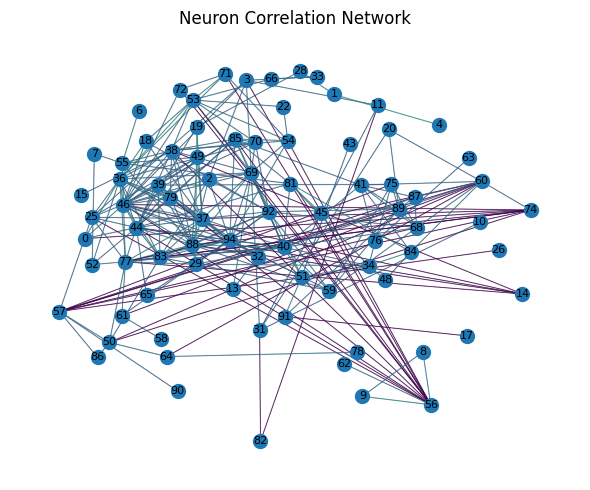

Top 10 highest correlations:
Neurons 19 and 29: 0.643
Neurons 36 and 53: 0.575
Neurons 1 and 4: 0.545
Neurons 83 and 88: 0.534
Neurons 37 and 88: 0.524
Neurons 88 and 94: 0.517
Neurons 45 and 81: 0.515
Neurons 54 and 85: 0.514
Neurons 77 and 88: 0.502
Neurons 34 and 84: 0.494


In [46]:
import networkx as nx
from scipy.stats import pearsonr
from sklearn.manifold import MDS
from umap import UMAP

# Assuming spiking_data and total_trace are already defined as per your code
# using_data = spiking_data
# data_type = "spikes"
# threshold = 0.1

using_data = total_trace
data_type = "trace"
threshold = 0.3

# Step 1: Calculate correlation matrix
def calculate_correlation_matrix(data):
    num_neurons = data.shape[1]
    corr_matrix = np.zeros((num_neurons, num_neurons))
    for i in range(num_neurons):
        for j in range(i, num_neurons):
            corr, _ = pearsonr(data[:, i], data[:, j])
            corr_matrix[i, j] = corr
            corr_matrix[j, i] = corr
    return corr_matrix

# Calculate correlation based on spiking data
spike_corr_matrix = calculate_correlation_matrix(using_data)

# Step 2: Create a network graph
G = nx.Graph()
num_neurons = spike_corr_matrix.shape[0]

for i in range(num_neurons):
    for j in range(i+1, num_neurons):
        if spike_corr_matrix[i, j] > threshold or spike_corr_matrix[i, j] < -threshold:  # You can adjust this threshold
            G.add_edge(i, j, weight=spike_corr_matrix[i, j])

# Step 3: Use Multidimensional Scaling (MDS) to get 2D positions
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
distances = 1 - spike_corr_matrix  # Convert correlations to distances
positions = mds.fit_transform(distances)

# Step 4: Visualize the network
plt.figure(figsize=(6, 5))
nx.draw_networkx_nodes(G, positions, node_size=100)
nx.draw_networkx_edges(G, positions, alpha=0.2)
nx.draw_networkx_labels(G, positions, font_size=8)

# Add colorbar to show correlation strength
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
edges = nx.draw_networkx_edges(G, positions, edge_color=edge_colors, width=0.5, 
                               edge_cmap=plt.cm.viridis, edge_vmin=0, edge_vmax=1)

plt.title('Neuron Correlation Network')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'Figures-cebra/PV_{mouse_num}_{inactivation}_{data_type}_network_2d')
plt.show()

# Step 5: Print highest correlations
top_correlations = []
for i in range(num_neurons):
    for j in range(i+1, num_neurons):
        top_correlations.append((i, j, spike_corr_matrix[i, j]))

top_correlations.sort(key=lambda x: x[2], reverse=True)
print("Top 10 highest correlations:")
for i, j, corr in top_correlations[:10]:
    print(f"Neurons {i} and {j}: {corr:.3f}")

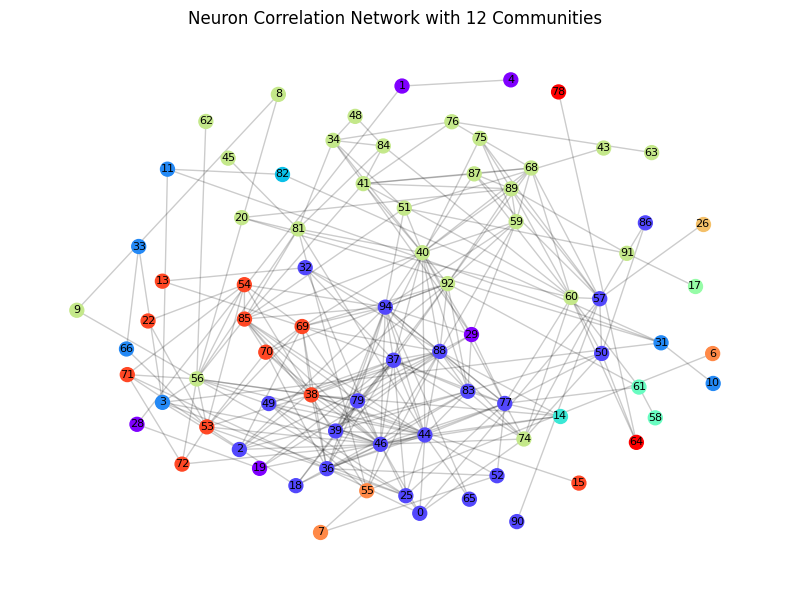

Community 1 indices: [1, 4, 19, 28, 29]
Community 2 indices: [0, 2, 18, 25, 32, 36, 37, 39, 44, 46, 49, 50, 52, 57, 65, 77, 79, 83, 86, 88, 90, 94]
Community 3 indices: [3, 10, 11, 31, 33, 66]
Community 4 indices: [82]
Community 5 indices: [14]
Community 6 indices: [58, 61]
Community 7 indices: [17]
Community 8 indices: [8, 9, 20, 34, 40, 41, 43, 45, 48, 51, 56, 59, 60, 62, 63, 68, 74, 75, 76, 81, 84, 87, 89, 91, 92]
Community 9 indices: [26]
Community 10 indices: [6, 7, 55]
Community 11 indices: [13, 15, 22, 38, 53, 54, 69, 70, 71, 72, 85]
Community 12 indices: [64, 78]

Top 3 largest communities:
Community 1 indices: [8, 9, 20, 34, 40, 41, 43, 45, 48, 51, 56, 59, 60, 62, 63, 68, 74, 75, 76, 81, 84, 87, 89, 91, 92]
Community 2 indices: [0, 2, 18, 25, 32, 36, 37, 39, 44, 46, 49, 50, 52, 57, 65, 77, 79, 83, 86, 88, 90, 94]
Community 3 indices: [13, 15, 22, 38, 53, 54, 69, 70, 71, 72, 85]


In [47]:
import networkx as nx
from scipy.stats import pearsonr
from sklearn.manifold import MDS

# Step 1: Calculate correlation matrix
def calculate_correlation_matrix(data):
    num_neurons = data.shape[1]
    corr_matrix = np.zeros((num_neurons, num_neurons))
    for i in range(num_neurons):
        for j in range(i, num_neurons):
            corr, _ = pearsonr(data[:, i], data[:, j])
            corr_matrix[i, j] = corr
            corr_matrix[j, i] = corr
    return corr_matrix

# Calculate correlation based on spiking data
spike_corr_matrix = calculate_correlation_matrix(using_data)

# Create the graph
G = nx.Graph()
num_neurons = spike_corr_matrix.shape[0]
for i in range(num_neurons):
    for j in range(i+1, num_neurons):
        if abs(spike_corr_matrix[i, j]) > threshold:
            G.add_edge(i, j, weight=spike_corr_matrix[i, j])

# Use MDS to get 2D positions
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
distances = 1 - np.abs(spike_corr_matrix)  # Convert correlations to distances
positions = mds.fit_transform(distances)

# Use Louvain community detection
communities = list(nx.community.louvain_communities(G))

# Visualize the network with community colors
plt.figure(figsize=(8, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G, positions, nodelist=community, node_color=[colors[i]] * len(community), node_size=100)
nx.draw_networkx_edges(G, positions, alpha=0.2)
nx.draw_networkx_labels(G, positions, font_size=8)

plt.title(f'Neuron Correlation Network with {len(communities)} Communities')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'Figures-cebra/PV_{mouse_num}_{inactivation}__{data_type}.png')
plt.show()

# Print community indices
for i, community in enumerate(communities):
    print(f"Community {i+1} indices: {sorted(community)}")

# If you specifically want 3 main communities, you can sort and select the top 3 by size
top_3_communities = sorted(communities, key=len, reverse=True)[:3]

print("\nTop 3 largest communities:")
for i, community in enumerate(top_3_communities):
    print(f"Community {i+1} indices: {sorted(community)}")

In [48]:
#### calculating temporal correlations ####

def time_lagged_correlation(x, y, max_lag):
    corrs = []
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            corr, _ = pearsonr(x[-lag:], y[:lag])
        elif lag > 0:
            corr, _ = pearsonr(x[:-lag], y[lag:])
        else:
            corr, _ = pearsonr(x, y)
        corrs.append(corr)
    return np.array(corrs)


# Step 1: Compute time-lagged correlation matrix
max_lag = 10 
n_neurons = using_data.shape[1]
corr_matrix = np.zeros((n_neurons, n_neurons, 2*max_lag + 1))

for i in range(n_neurons):
    for j in range(n_neurons):
        corr_matrix[i, j] = time_lagged_correlation(using_data[:, i], using_data[:, j], max_lag)

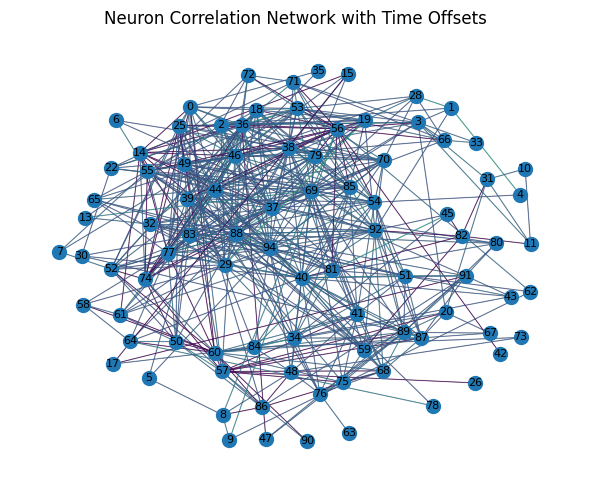

Top 10 highest correlations:
Neurons 19 and 29: 0.643
Neurons 57 and 60: 0.594
Neurons 36 and 53: 0.575
Neurons 1 and 4: 0.545
Neurons 83 and 88: 0.535
Neurons 37 and 88: 0.524
Neurons 88 and 94: 0.517
Neurons 45 and 81: 0.515
Neurons 54 and 85: 0.515
Neurons 77 and 88: 0.502


In [49]:
# Assuming corr_matrix is your 3D correlation matrix with shape (num_neurons, num_neurons, num_lags)

# Step 1: Prepare data
num_neurons = corr_matrix.shape[0]
num_lags = corr_matrix.shape[2]

# Step 2: Create a network graph
G2 = nx.Graph()
for i in range(num_neurons):
    for j in range(i+1, num_neurons):
        max_corr = np.max(np.abs(corr_matrix[i, j]))
        max_idx = np.argmax(np.abs(corr_matrix[i, j]))
        if max_corr > 0.25:  # You can adjust this threshold
            G2.add_edge(i, j, weight=max_corr * np.sign(corr_matrix[i, j, max_idx]))

# Step 3: Use Multidimensional Scaling (MDS) to get 2D positions
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
max_corr_matrix = np.max(np.abs(corr_matrix), axis=2)
distances = 1 - max_corr_matrix  # Convert max correlations to distances
positions = mds.fit_transform(distances)

# Step 4: Visualize the network
plt.figure(figsize=(6, 5))
nx.draw_networkx_nodes(G2, positions, node_size=100)
nx.draw_networkx_edges(G2, positions, alpha=0.2)
nx.draw_networkx_labels(G2, positions, font_size=8)

# Add colorbar to show correlation strength
edge_colors = [G2[u][v]['weight'] for u, v in G2.edges()]
edges = nx.draw_networkx_edges(G2, positions, edge_color=edge_colors, width=0.5,
                               edge_cmap=plt.cm.viridis, edge_vmin=0, edge_vmax=1)

plt.title('Neuron Correlation Network with Time Offsets')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'Figures-cebra/PV_{mouse_num}_{inactivation}_time_lagged_network_2d.png')
plt.show()

# Step 5: Print highest correlations
top_correlations = []
for i in range(num_neurons):
    for j in range(i+1, num_neurons):
        max_corr = np.max(np.abs(corr_matrix[i, j]))
        top_correlations.append((i, j, max_corr))

top_correlations.sort(key=lambda x: x[2], reverse=True)
print("Top 10 highest correlations:")
for i, j, corr in top_correlations[:10]:
    print(f"Neurons {i} and {j}: {corr:.3f}")

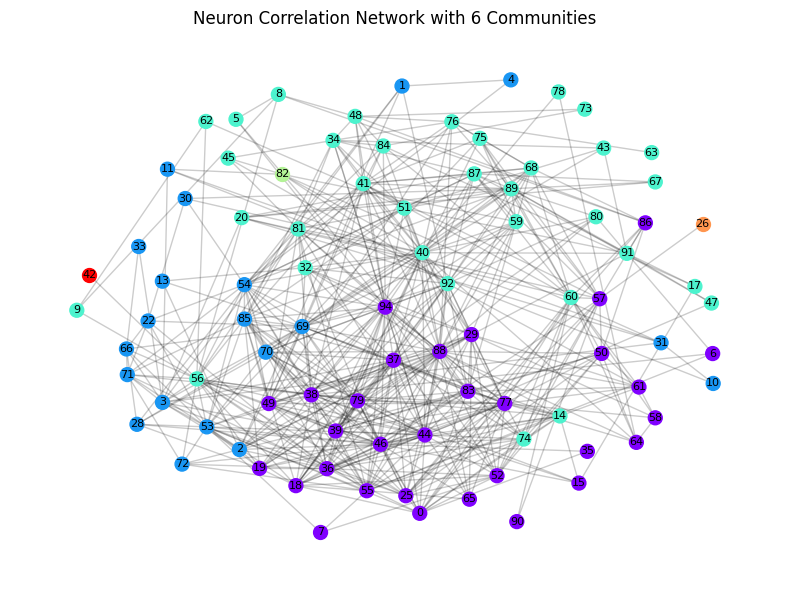

Community 1 indices: [0, 6, 7, 15, 18, 19, 25, 29, 35, 36, 37, 38, 39, 44, 46, 49, 50, 52, 55, 57, 58, 61, 64, 65, 77, 79, 83, 86, 88, 90, 94]
Community 2 indices: [1, 2, 3, 4, 10, 11, 13, 22, 28, 30, 31, 33, 53, 54, 66, 69, 70, 71, 72, 85]
Community 3 indices: [5, 8, 9, 14, 17, 20, 32, 34, 40, 41, 43, 45, 47, 48, 51, 56, 59, 60, 62, 63, 67, 68, 73, 74, 75, 76, 78, 80, 81, 84, 87, 89, 91, 92]
Community 4 indices: [82]
Community 5 indices: [26]
Community 6 indices: [42]

Top 3 largest communities:
Community 1 indices: [5, 8, 9, 14, 17, 20, 32, 34, 40, 41, 43, 45, 47, 48, 51, 56, 59, 60, 62, 63, 67, 68, 73, 74, 75, 76, 78, 80, 81, 84, 87, 89, 91, 92]
Community 2 indices: [0, 6, 7, 15, 18, 19, 25, 29, 35, 36, 37, 38, 39, 44, 46, 49, 50, 52, 55, 57, 58, 61, 64, 65, 77, 79, 83, 86, 88, 90, 94]
Community 3 indices: [1, 2, 3, 4, 10, 11, 13, 22, 28, 30, 31, 33, 53, 54, 66, 69, 70, 71, 72, 85]


In [50]:
# Use MDS to get 2D positions
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
distances = 1 - np.abs(spike_corr_matrix)  # Convert correlations to distances
positions = mds.fit_transform(distances)

# Use Louvain community detection
communities = list(nx.community.louvain_communities(G2))

# Visualize the network with community colors
plt.figure(figsize=(8, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G2, positions, nodelist=community, node_color=[colors[i]] * len(community), node_size=100)
nx.draw_networkx_edges(G2, positions, alpha=0.2)
nx.draw_networkx_labels(G2, positions, font_size=8)

plt.title(f'Neuron Correlation Network with {len(communities)} Communities')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'Figures-cebra/PV_{mouse_num}_{inactivation}_timelagged_network-communities_{data_type}.png')
plt.show()

# Print community indices
for i, community in enumerate(communities):
    print(f"Community {i+1} indices: {sorted(community)}")

# If you specifically want 3 main communities, you can sort and select the top 3 by size
top_3_communities = sorted(communities, key=len, reverse=True)[:3]

print("\nTop 3 largest communities:")
for i, community in enumerate(top_3_communities):
    print(f"Community {i+1} indices: {sorted(community)}")